In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [8]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
XTR = X_train_orig/255
YTR = convert_to_one_hot(Y_train_orig,6).T
XT = X_test_orig/255
YT = convert_to_one_hot(Y_test_orig,6).T

In [3]:
m = 1080
epochs = 500
learn_rate = 0.009

Test accuracy:  0.8583333333333333


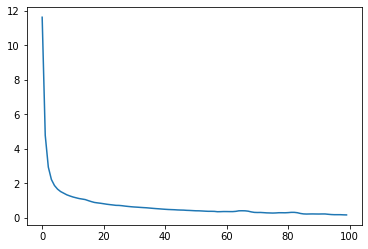

In [13]:
X = tf.placeholder(tf.float32, shape=[None, 64, 64, 3], name="X")
Y = tf.placeholder(tf.float32, shape=[None, 6], name="Y")

W1 = tf.Variable(tf.random_normal([4,4,3,8]), name="W1")
W2 = tf.Variable(tf.random_normal([2,2,8,16]), name="W2")

H1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME', data_format='NHWC')
A1 = tf.nn.relu(H1)
P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides=[1,8,8,1], padding='SAME')

H2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME', data_format='NHWC')
A2 = tf.nn.relu(H2)
P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1,4,4,1], padding='SAME')

F2 = tf.layers.flatten(P2)
logits = tf.layers.dense(F2,6)

residuals = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y)
loss = tf.reduce_mean(residuals)

# optimizer = tf.train.GradientDescentOptimizer(learn_rate)
optimizer = tf.train.AdamOptimizer(learn_rate)
updates = optimizer.minimize(loss)

num_batches = int(m/64)
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    for i in range(epochs):
        batch_loss = 0.0
        batches = random_mini_batches(XTR, YTR, 64)
        for batch in batches:
            batch_x, batch_y = batch
            _,lo = sess.run([updates, loss], feed_dict={X:batch_x,  Y: batch_y})
            batch_loss = batch_loss + lo
        losses.append(batch_loss/num_batches)
    
    probs = tf.nn.softmax(logits)
    corrects = tf.equal(tf.argmax(probs, 1), tf.argmax(Y, 1))
    accuracies = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuraciesV = sess.run(accuracies, feed_dict={X:XT,  Y: YT})
    print('Test accuracy: ', accuraciesV/XT.shape[0])

plt.plot(losses)
